# Loading NYU Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np

import timeit
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data

import os
import scipy
class DepthDataset(Dataset):
    def __init__(self, data_dir):
        sub_folders=os.listdir(data_dir+'/RGB')
        self.data_files=[]
        for folder in sub_folders:
            files=os.listdir(data_dir+'/RGB/'+folder)
            for file in files:
                self.data_files.append(folder+'/'+file)
        self.data_dir=data_dir
#         sort(self.data_files)      

    def __getitem__(self, index):
        name=self.data_files[index]
        img=torch.from_numpy(h5py.File(self.data_dir+'/RGB/'+name,'r')['rgbOut'].value).float()
        depth=torch.from_numpy(h5py.File(self.data_dir+'/DEP/'+name,'r')['depthOut'].value).float()
        return img,depth

    def __len__(self):
        print('len',len(self.data_files))
        return len(self.data_files)

In [3]:
dataset=DepthDataset('../Data')
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

In [4]:
N=dataset.__len__()
NUM_TRAIN = int(N*0.9)
NUM_VAL = N-NUM_TRAIN
print("NUM_TRAIN:",NUM_TRAIN,",NUM_VAL:",NUM_VAL)
batch_size=8#32
loader_train = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0),num_workers=8)
loader_val = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN),num_workers=8)

len 2344
NUM_TRAIN: 2109 ,NUM_VAL: 235


In [5]:
# image size = [304, 228]
# depth size = [74,55]
print(len(loader_train))

264


In [6]:
import torchvision.models as models

In [7]:
dtype = torch.cuda.FloatTensor

In [8]:
model = models.resnet50(pretrained=True)


In [9]:
mod = list(model.children())


In [10]:
mod.pop()

Linear (2048 -> 1000)

In [11]:
mod.pop()

AvgPool2d (
)

In [12]:
resnet50 = torch.nn.Sequential(*mod)

In [13]:
del model

In [14]:
class cropMore(nn.Module):
    def forward(self,x):
        N,C,H,W = x.size()
        return x[:,:,0:H-6,0:W-9].squeeze()

In [15]:
class unpooling(nn.Module):
    def __init__(self,H,W):
        super(unpooling, self).__init__()
        self.indices = torch.zeros(H,W)
        for i in range(H):
            for j in range(W):
                self.indices[i,j] = i*2*2*W+j*2
        self.unpool = nn.MaxUnpool2d(2)
    def forward(self, x):
        N,C,H,W = x.size()
        indices = self.indices.expand(N,C,H,W)
        y = self.unpool(x, Variable(indices.type(torch.cuda.LongTensor),requires_grad=False))
        return y

In [16]:
class upsampling(nn.Module):
    def __init__(self,C,H,W):
        super(upsampling, self).__init__()
        self.unpooling = unpooling(H,W)
        self.conv5 = nn.Conv2d(C,int(C/2),5,stride = 1,padding=2)
        self.ReLU = nn.ReLU()
        self.conv3 = nn.Conv2d(int(C/2),int(C/2),3,stride = 1,padding=1)
        self.conv5_2 = nn.Conv2d(C,int(C/2),5,stride = 1,padding=2)
    def forward(self, x):
        y0 = self.unpooling(x)
        y1 = self.conv5(y0)
        y1 = self.ReLU(y1)
        y1 = self.conv3(y1)
        y2 = self.conv5_2(y0)
        y3 = y1+y2
        y = self.ReLU(y3)
        return y

In [17]:
upsample = torch.nn.Sequential(
    nn.Conv2d(2048,1024,1,stride = 1,padding=0),
    nn.BatchNorm2d(1024), #1024*10*8
    upsampling(1024,10,8),
    upsampling(512,20,16),
    upsampling(256,40,32),
    #upsampling(128,80,64),
    nn.Conv2d(128,1,3,stride = 1,padding=1),
    nn.ReLU(),
    cropMore()
    )
    

In [ ]:
FCRN = torch.nn.Sequential(
    resnet50(),
    upsample()
    )

In [ ]:
FCRN.type(dtype)

In [18]:
resnet50.type(dtype)
upsample.type(dtype)

Sequential (
  (0): Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (2): upsampling (
    (unpooling): unpooling (
      (unpool): MaxUnpool2d (
      )
    )
    (conv5): Conv2d(1024, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (ReLU): ReLU ()
    (conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_2): Conv2d(1024, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (3): upsampling (
    (unpooling): unpooling (
      (unpool): MaxUnpool2d (
      )
    )
    (conv5): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (ReLU): ReLU ()
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5_2): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (4): upsampling (
    (unpooling): unpooling (
      (unpool): MaxUnpool2d (
      )
    )
    (conv5): Conv2d(256, 128, kernel_size=(5

## Model Testing

In [19]:
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    #pred=new_model(x_var)
    x1 = resnet50(x_var)
    pred = upsample(x1)
    print(pred.size())
    break

OSError: Traceback (most recent call last):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-2-6006da2205e4>", line 18, in __getitem__
    img=torch.from_numpy(h5py.File(self.data_dir+'/RGB/'+name,'r')['rgbOut'].value).float()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/h5py/_hl/files.py", line 271, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, swmr=swmr)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/h5py/_hl/files.py", line 101, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper (/tmp/pip-huypgcah-build/h5py/_objects.c:2840)
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper (/tmp/pip-huypgcah-build/h5py/_objects.c:2798)
  File "h5py/h5f.pyx", line 78, in h5py.h5f.open (/tmp/pip-huypgcah-build/h5py/h5f.c:2117)
OSError: Unable to open file (File read failed: time = sat jun  3 07:12:02 2017
, filename = '../data/rgb/bathrooms_part4/bathroom_0050', file descriptor = 59, errno = 21, error message = 'is a directory', buf = 0x7ffd7ab0a1d0, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)


In [ ]:
testModel = nn.MaxPool2d(2,2,return_indices = True)
testModel.type(dtype)

In [ ]:
x_var=Variable(torch.zeros(1,3,6,10).type(dtype),requires_grad=False)
#pred=new_model(x_var)
y,ind = testModel(x_var)
print(x_var.size())
print(y.size())
print(ind.size())
print(ind)


In [ ]:
testModel = unpooling(10,8)
testModel.type(dtype)

In [ ]:
x_var=Variable(torch.ones(1,4,10,8).type(dtype),requires_grad=False)
#pred=new_model(x_var)
y = testModel(x_var)
print(y)

## Training

In [19]:



#images_var=Variable(images_pytorch.type(dtype),requires_grad=False)
#depths_var=Variable(depths_pytorch.type(dtype),requires_grad=False)

def log_loss(pred,y):
    ep = 1e-6
    N,W,H = pred.size()
    pred = pred.contiguous().view(N,-1)
    y = y.view(N,-1)
    
    pred = pred*(y>0).type(dtype)
    y = y*(y>0).type(dtype)
    
    y = y+ep
    d = pred - y.log()
    #d[y <= 0] = 0
    n = W*H
    loss = (d.pow(2).sum(1) / n - 0.5 / n/n * d.sum(1).pow(2)).sum()
    loss /= N
    return loss
    
def tv_loss(img, tv_weight = 5e-6):
    N,H,W = img.size()
    img1 = img[:,1:H,1:W]
    img2 = img[:,1:H,0:W-1]
    img3 = img[:,0:H-1,1:W]
    loss = torch.sum((img1 - img2)**2+(img1 - img3)**2)*tv_weight
    #loss_var = Variable(loss)
    return loss

def loss_function(pred,y,tv_weight = 5e-6):
    loss = log_loss(pred,y) + tv_loss(pred, tv_weight)
    return loss

In [20]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

In [21]:
for param in resnet50.parameters():
    param.requires_grad = True

In [22]:
lr=1e-6
reg=0.0#1e-4
adam_optim2=optim.Adam(resnet50.parameters(),lr=lr,weight_decay=reg)

In [23]:
print_every=400
lr=1e-3
reg=0.0#1e-4
adam_optim=optim.Adam(upsample.parameters(),lr=lr,weight_decay=reg)

epoch: 0 average training loss: 29.88 validation loss: 27.40
epoch: 1 average training loss: 27.65 validation loss: 27.12
epoch: 2 average training loss: 27.46 validation loss: 26.99
epoch: 3 average training loss: 27.37 validation loss: 26.92
epoch: 4 average training loss: 27.32 validation loss: 26.89
epoch: 5 average training loss: 27.28 validation loss: 26.87
epoch: 6 average training loss: 27.26 validation loss: 26.86
epoch: 7 average training loss: 27.26 validation loss: 26.86
epoch: 8 average training loss: 27.28 validation loss: 27.07
epoch: 9 average training loss: 27.31 validation loss: 26.99
epoch: 10 average training loss: 27.30 validation loss: 26.88
epoch: 11 average training loss: 27.28 validation loss: 26.90
epoch: 12 average training loss: 27.28 validation loss: 26.88
epoch: 13 average training loss: 27.28 validation loss: 26.86
epoch: 14 average training loss: 27.24 validation loss: 26.85
epoch: 15 average training loss: 27.22 validation loss: 26.84
epoch: 16 average 

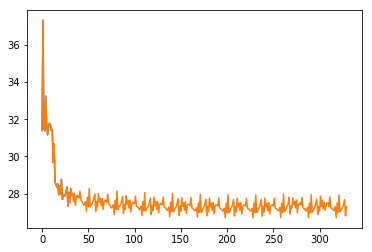

In [24]:

def train(model, loss_fn, optimizer, optimizer2, num_epochs = 1, plot_every = 10):
    losses = []
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_train_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            x1 = resnet50(x_var)
            pred = model(x1)
            loss = loss_fn(pred, y_var)
            losses.append(loss.data.cpu().numpy())
            
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_train_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            optimizer2.zero_grad()
            loss.backward()
            optimizer.step()
            optimizer2.step()
            del x,y
        avg_train_loss/=num_batches
        num_batches=0
        avg_val_loss=0
        for t,(x,y) in enumerate(loader_val):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            x1 = resnet50(x_var)
            pred = model(x1)
            loss=loss_fn(pred,y_var)
            avg_val_loss+=loss.data[0]
            num_batches+=1
            del x,y
        avg_val_loss/=num_batches
        print("epoch:",epoch,"average training loss: %.2f"%avg_train_loss,"validation loss: %.2f" %avg_val_loss)
        if(epoch % plot_every == 0):
            plt.plot(losses)
            

train(upsample,log_loss,adam_optim,adam_optim2,num_epochs = 20)

In [ ]:
del upsample
del resnet50
del model

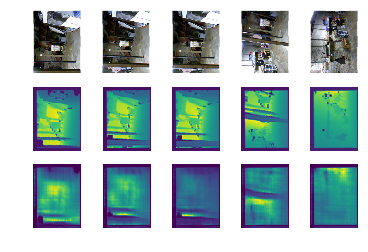

In [25]:
%matplotlib inline

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# visualize 5 images
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    upsample.train(False)
    x1 = resnet50(x_var)
    pred = upsample(x1)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

epoch: 0 average training loss: 27.25 validation loss: 26.85
epoch: 1 average training loss: 27.26 validation loss: 26.87
epoch: 2 average training loss: 27.22 validation loss: 26.84
epoch: 3 average training loss: 27.19 validation loss: 26.82
epoch: 4 average training loss: 27.19 validation loss: 26.82
epoch: 5 average training loss: 27.18 validation loss: 26.82
epoch: 6 average training loss: 27.18 validation loss: 26.83
epoch: 7 average training loss: 27.18 validation loss: 26.82
epoch: 8 average training loss: 27.18 validation loss: 26.82
epoch: 9 average training loss: 27.18 validation loss: 26.82
epoch: 10 average training loss: 27.18 validation loss: 26.82
epoch: 11 average training loss: 27.18 validation loss: 26.82
epoch: 12 average training loss: 27.18 validation loss: 26.81
epoch: 13 average training loss: 27.18 validation loss: 26.81
epoch: 14 average training loss: 27.18 validation loss: 26.80
epoch: 15 average training loss: 27.18 validation loss: 26.80
epoch: 16 average 

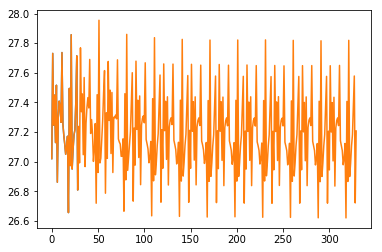

In [28]:
train(upsample,log_loss,adam_optim,adam_optim2,num_epochs = 20)

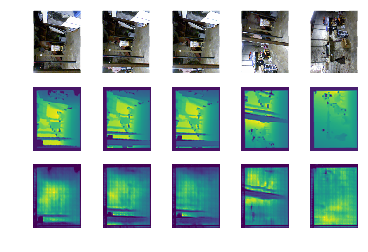

In [27]:
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    upsample.train(False)
    x1 = resnet50(x_var)
    pred = upsample(x1)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

In [ ]:
def evaluate(loader):
    ep = 1e-7

    thresh_1 = 0
    thresh_2 = 0
    abs_diff = 0
    rmse = 0

    for t,(x,y) in enumerate(loader):
        x_var=Variable(x.type(dtype),requires_grad=False)
        y_var=Variable(y.type(dtype),requires_grad=False)
        coarse_model.train(False)
        pred=coarse_model(x_var)

        #print(y_var.data.cpu().numpy())
        y_var=y_var.data.cpu().numpy() + ep
        pred=pred.data.cpu().numpy() + ep
        num_var = np.shape(y_var)[0]*np.shape(y_var)[1]*np.shape(y_var)[2]

        # threshold
        thresh_mat = np.zeros_like(y_var)
        thresh_mat[np.maximum(y_var / pred, pred / y_var) < 1.25] = 1
        thresh_1 += np.sum(thresh_mat)
        thresh_2 += num_var
        #print('t1 = %d, t2 = %d', thresh_1, thresh_2)

        # relative absolute diffe
        abs_diff += np.sum(np.absolute(y_var - pred) / y_var) / num_var

        rmse += np.sqrt(np.sum((y_var - pred) * (y_var - pred)) / num_var)


    abs_diff /= len(loader_train)

    print('percentage within threshold: ', thresh_1 / thresh_2)
    print('relative absolute diff = ', abs_diff)
    print('rmse = ', rmse)

In [ ]:
evaluate(loader_val)

In [ ]:

def train_overfit(model, loss_fn, optimizer, num_epochs = 1, plot_every = 10):
    losses = []
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_train_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=model(x_var)
            loss = loss_fn(pred, y_var)
            losses.append(loss.data.cpu().numpy())
            
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_train_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break
        avg_train_loss/=num_batches
        num_batches=0

        print("epoch:",epoch,"average training loss: %.2f"%avg_train_loss)
        if(epoch % plot_every == 0):
            plt.plot(losses)
            

train_overfit(coarse_model,loss_log,adam_optim,40)

In [ ]:
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

In [ ]:
%matplotlib inline
a = [1,2,3,4]#np.array([1,2,3,4])
a.append(5)
plt.plot(a)

In [ ]:
print(loader_train)

In [ ]:
a = torch.zeros(3,3)
a[0,1] = 2
a[0,2] = 4
b = torch.sum(a,0)

print(a)
print(b)

In [ ]:
class UnConv(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        channel1 = nn.Sequential(
            nn.MaxUnpool2d(kernel_size=2, stride=None, padding=0),
            nn.Conv2d(C,int(C/2),5,stride = 1,padding=2),
            nn.ReLU()
            )
        channel1.type(dtype)
        return channel1(x)